In [1]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [2]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
from scipy.stats import ks_2samp

warnings.filterwarnings("ignore")

# %matplotlib inline
# mpld3.enable_notebook()

In [4]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [5]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

In [6]:
def trim_window_values(window, trim_stddev):
    """
    Trims the values in the window to within the specified number of standard deviations from the mean.

    Parameters:
        window (deque): The rolling window of data points.
        trim_stddev (float): The number of standard deviations to trim data points.

    Returns:
        np.array: The trimmed values.
    """
    window_mean = np.mean(window)
    window_std = np.std(window)
    lower_bound = window_mean - trim_stddev * window_std
    upper_bound = window_mean + trim_stddev * window_std

    return deque(np.clip(window, lower_bound, upper_bound), maxlen=len(window))

In [16]:
def detect_drift_using_KS(window, window_size):
    """
    Detects drift in the current window using the Kolmogorov-Smirnov test.

    Parameters:
        window (np.array): The current window of data points.
        window_size (int): The size of the rolling window.

    Returns:
        tuple: (bool, str) indicating whether drift is detected and the type of drift.
    """
    first_half = window[: window_size // 2]
    second_half = window[window_size // 2 :]
    ks_stat, p_value = ks_2samp(first_half, second_half)

    if p_value < 0.001:
        mean_diff = np.mean(second_half) - np.mean(first_half)
        if np.abs(mean_diff) > np.std(window):
            return True, "Sudden Drift"
        elif np.abs(mean_diff) > 0:
            return True, "Linear Drift"
        else:
            return True, "Gradual Drift"

    return False, None

In [8]:
def detect_feature_drift(feature_data, window_size=100, trim_stddev=1):
    """
    Detects feature drift in the given feature data using a rolling window approach.

    Parameters:
        feature_data (pd.Series): The feature data to monitor for drift.
        window_size (int): The size of the rolling window.
        trim_stddev (float): The number of standard deviations to trim data points.

    Returns:
        drift_points (list): Indices where drift is detected.
        drift_types (list): Types of drift detected at each drift point.
        moving_averages (pd.Series): Moving averages of the feature data with corresponding indices.
    """
    window_x = deque(maxlen=window_size)
    drift_points = []
    drift_types = []
    moving_avg = pd.Series(dtype=float)

    # Initialize the rolling window with the first window_size data points
    window_x.extend(feature_data.head(window_size))
    moving_avg[window_size - 1] = np.mean(window_x)

    for idx, xi in enumerate(feature_data[window_size:], start=window_size):
        # Add the new data point to the rolling window
        window_x.append(xi)

        # Trim the window values using the separate function
        # window_x = trim_window_values(window_x, trim_stddev)

        # Detect drift using the separate function
        drift_detected, drift_type = detect_drift_using_KS(
            np.array(window_x), window_size
        )

        if drift_detected:
            drift_points.append(idx)
            drift_types.append(drift_type)

        moving_avg[idx] = np.mean(window_x)

    return drift_points, drift_types, moving_avg


# dp, dt, ma = detect_feature_drift(X_df["n0"])
# len(dp)

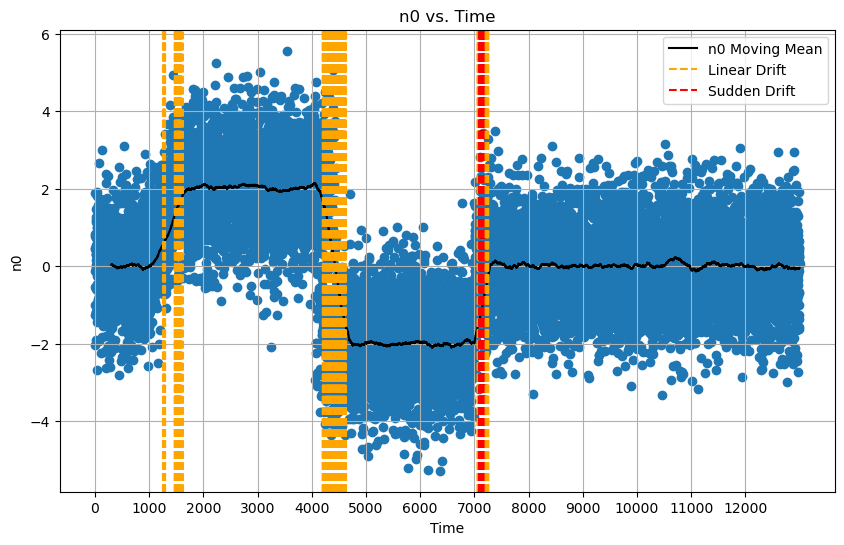

In [14]:
def plot_feature_drift(feature_name, feature_data, window_size=300):
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_data.index, feature_data, marker="o")

    moving_mean = feature_data.rolling(window=window_size).mean()
    plt.plot(
        feature_data.index,
        moving_mean,
        color="black",
        linestyle="-",
        label=f"{feature_name} Moving Mean",
    )

    drift_points, drift_types, moving_avg = detect_feature_drift(
        feature_data, window_size, 3
    )

    # plt.plot(moving_avg.index, moving_avg, color='orange', linestyle='-', label=f'{feature} Moving Mean with trimming')

    drift_type_temp_label = []
    for idx, drift_point in enumerate(drift_points):
        drift_type = drift_types[idx]
        color = (
            "red"
            if drift_type == "Sudden Drift"
            else "orange" if drift_type == "Linear Drift" else "blue"
        )
        plt.axvline(
            x=drift_point,
            color=color,
            linestyle="--",
            label=f"{drift_type}" if drift_type not in drift_type_temp_label else "",
        )
        drift_type_temp_label.append(drift_type)

    plt.title(f"{feature_name} vs. Time")
    plt.xlabel("Time")
    plt.ylabel(f"{feature_name}")
    plt.grid(True)
    plt.xticks(np.arange(0, len(feature_data), 1000))
    plt.legend()
    plt.show()

    # print(f"Feature: {feature_name}")
    # for dp, dt in zip(drift_points, drift_types):
    #     print(f"Drift detected at index {dp}: {dt}")


plot_feature_drift("n0", X_df["n0"])

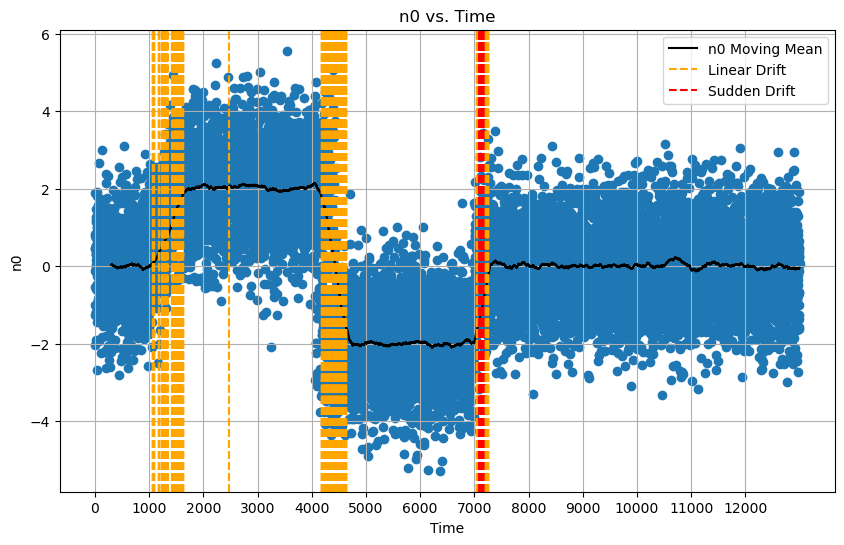

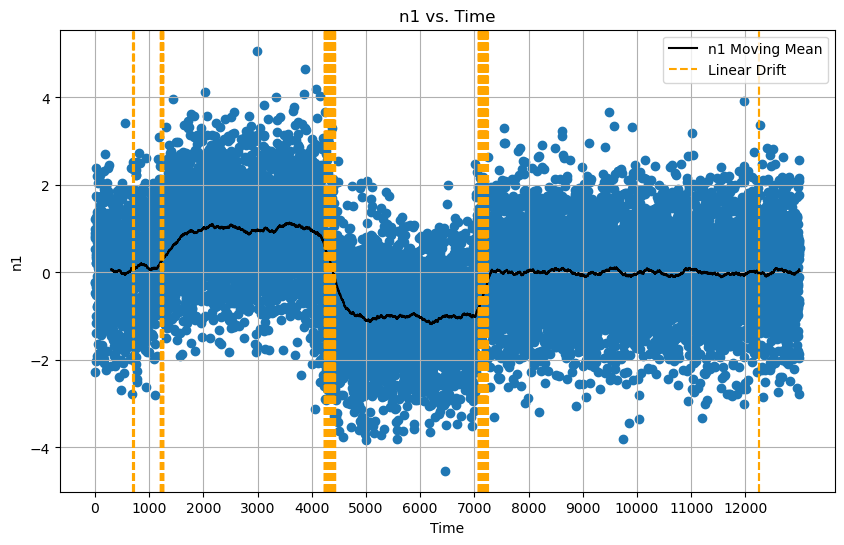

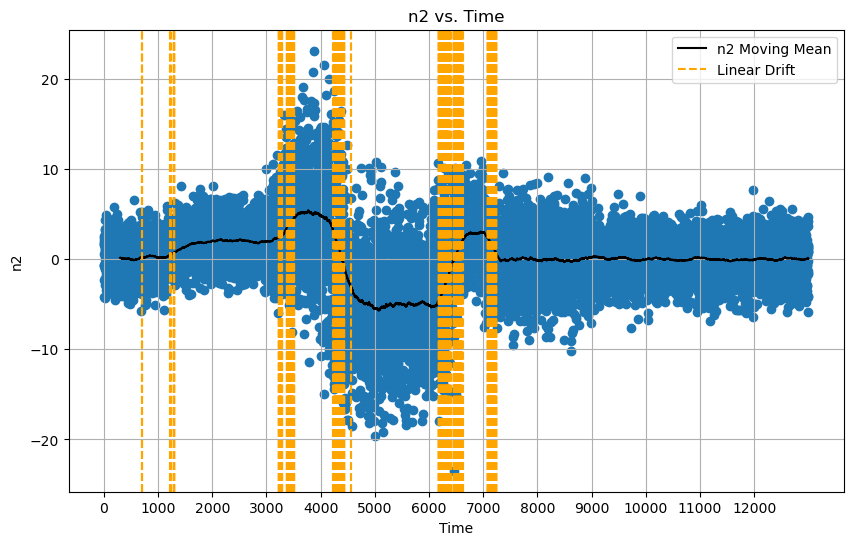

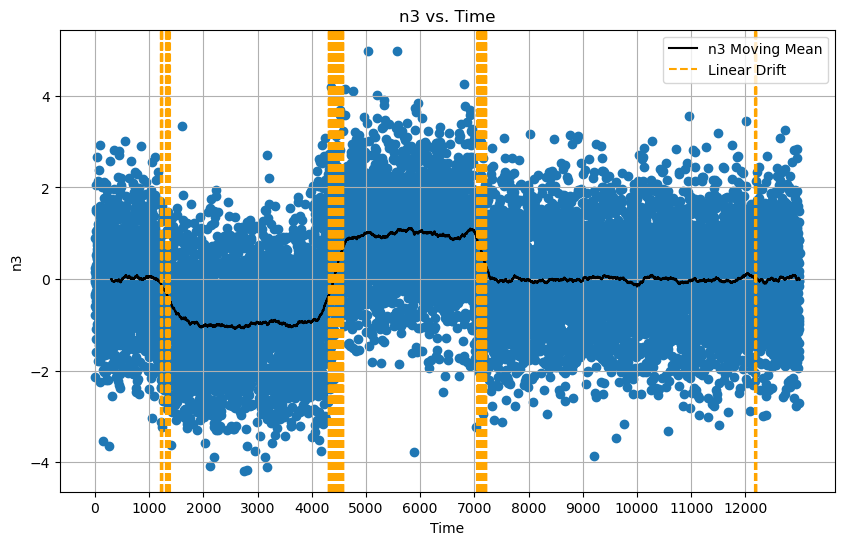

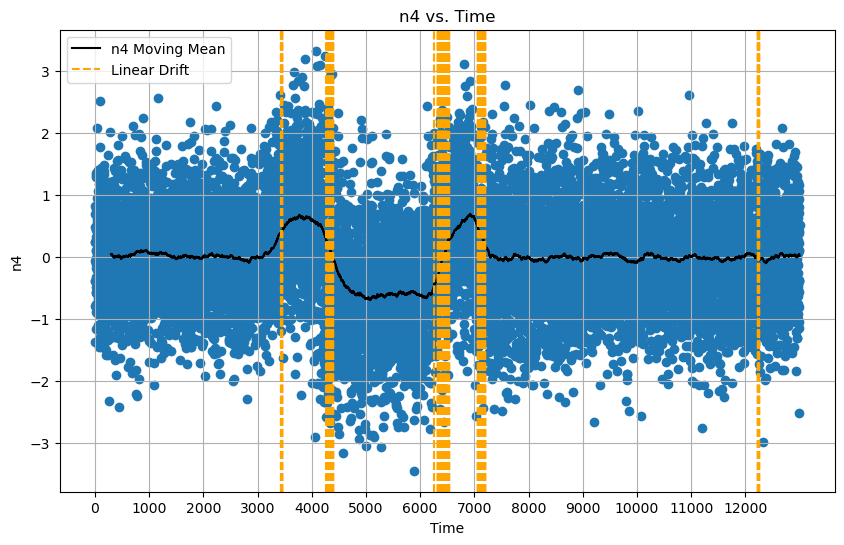

In [17]:
for feature in non_cat_columns:
    plot_feature_drift(feature, X_df[feature])